In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter



In [16]:
desired_cols = ['osg_fish1_x','osg_fish1_y', 'osg_fish1_z','framenumber','real_fish_x', 'real_fish_y', 'real_fish_z','velocity', 'Stim_Flag', 'Stim_Flag_dir', 'exp_uuid', 'frame_diff', 'steps',
       'xs_rf', 'ys_rf', 'zs_rf']
df = pd.read_csv(r'C:\PhD\experiments\fish_experiments\FishSizeKinematics\data\0712vr3_1_112_a28.csv_processed.csv', usecols=desired_cols)


C:\Users\kkumari\AppData\Local\Temp\ipykernel_21444\1761184208.py:3: DtypeWarning: Columns (4,5,6,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\PhD\experiments\fish_experiments\FishSizeKinematics\data\0712vr3_1_112_a28.csv_processed.csv', usecols=desired_cols)


In [17]:
def calc_proximity(df):

    print(f'lenght of df before dropna: {len(df)}')

    df= df.dropna()

    x_rf, y_rf, z_rf = pd.to_numeric(df['xs_rf']), pd.to_numeric(df['ys_rf']), pd.to_numeric(df['zs_rf'])
    x_vf, y_vf, z_vf = pd.to_numeric(df['osg_fish1_x']), pd.to_numeric(df['osg_fish1_y']), pd.to_numeric(df['osg_fish1_z'])

    
# # Correct way to assign values using .loc to avoid SettingWithCopyWarning
#     df.loc[:, ['x_rf', 'y_rf', 'z_rf', 'x_vf', 'y_vf', 'z_vf']] = x_rf, y_rf, z_rf, x_vf, y_vf, z_vf
    
    df.loc[:, 'x_rf'] = x_rf
    df.loc[:, 'y_rf'] = y_rf
    df.loc[:, 'z_rf'] = z_rf
    df.loc[:, 'x_vf'] = x_vf
    df.loc[:, 'y_vf'] = y_vf
    df.loc[:, 'z_vf'] = z_vf
  
    # df = df[(df['z_rf'] >= -0.06) & (df['z_rf'] <= -0.04)]
    df['euclidean_distance'] = np.sqrt((x_rf-x_vf)**2 + (y_rf-y_vf)**2 + (z_rf-z_vf)**2)

    print(f'lenght of df after dropna: {len(df)}')

    return df

In [18]:
def coordinate_transition(df):

    heading_vf = df['heading_vf']
    x_rf, y_rf = df['x_rf'], df['y_rf']
    x_vf, y_vf = df['x_vf'], df['y_vf']

    # Calculate the relative position of the real fish to the virtual fish
    x_in, y_in = x_rf - x_vf, y_rf - y_vf

    x_o = x_in*np.cos(heading_vf) + y_in*np.sin(heading_vf)
    y_o = -x_in*np.sin(heading_vf) + y_in*np.cos(heading_vf)

    df.loc[:, 'x_o'] = x_o
    df.loc[:, 'y_o'] = y_o

    print(f'length of transitioned df: {len(df)}')

    return df

In [19]:
def check_angles(df):

    temp_relative_heading = df['heading_rf'] - df['heading_vf']
    temp_complementary_relative_heading =  df['heading_rf'] - (np.pi - df['heading_vf'])

    temp_relative_heading = np.array(temp_relative_heading)
    temp_complementary_relative_heading = np.array(temp_complementary_relative_heading)

    fig= plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(temp_relative_heading[:1000], label='temp_relative heading')
    ax.plot(temp_complementary_relative_heading[:1000], label='complementary relative heading')
    ax.legend()
    plt.show()

    relative_heading = np.where(np.abs(temp_relative_heading) < np.abs(temp_complementary_relative_heading), temp_relative_heading, temp_complementary_relative_heading)
    concat = np.concatenate((np.abs(temp_relative_heading).reshape(-1,1), np.abs(temp_complementary_relative_heading).reshape(-1,1)), axis=1)

    min_indices = np.argmin(concat, axis=1)

    # Initialize an empty list to store the minimum values
    min_values = []

    # Iterate over the indices and the two arrays simultaneously
    for index, (value_from_temp, value_from_complementary) in enumerate(zip(temp_relative_heading, temp_complementary_relative_heading)):
        # Check the index to determine which value to append to the min_values list
        if min_indices[index] == 0:
            min_values.append(value_from_temp)
        else:
            min_values.append(value_from_complementary)

    # Convert the list to a numpy array if needed
    min_values = np.array(min_values)

    print("Indices of minimum values:", min_indices[1:50])

    plt.figure()
    plt.plot(min_values[:10], label='Minimum Values')
    plt.legend()
    plt.title('Minimum Values from Concatenated Arrays')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

    min_relative_heading = min_values
    real_relative_heading = relative_heading

    print(f'shape of real_relative_heading: {real_relative_heading.shape}')
        
    threshold_radians = np.radians(180)
    relative_heading_follow = np.where(real_relative_heading <= threshold_radians, 1, 0)
    min_relative_heading_follow = np.where(min_relative_heading <= threshold_radians, 1, 0)

    print(f'proportion of time fish follows, using np.where: {np.mean(relative_heading_follow)}')
    print(f'proportion of time fish follows min, using manual calculation using for loop: {np.mean(min_relative_heading_follow)}')

    return real_relative_heading, min_relative_heading
    

In [20]:
def calc_relative_heading(df):
    df = df.dropna()
    df = calc_proximity(df)
    dt = 0.01

    df['dxs_rf'] = df['x_rf'].diff()
    df['dys_rf'] = df['y_rf'].diff()
    df['dxs_vf'] = df['x_vf'].diff()
    df['dys_vf'] = df['y_vf'].diff()

    # Step 1: Calculate the headings
    df['heading_rf'] = np.arctan2(df['dys_rf'], df['dxs_rf'])  # Heading for real fish
    df['heading_vf'] = np.arctan2(df['dys_vf'], df['dxs_vf'])  # Heading for virtual fish

    # Correcting the angle differences
    heading_difference = df['heading_rf'] - df['heading_vf']
    heading_difference_comp = df['heading_rf'] - (np.pi - df['heading_vf'])

    # Convert to numpy arrays and reshape for concatenation
    heading_difference = np.array(heading_difference).reshape(-1, 1)
    heading_difference_comp = np.array(heading_difference_comp).reshape(-1, 1)

    concat_heading = np.concatenate((np.abs(heading_difference), np.abs(heading_difference_comp)), axis=1)
    concat_heading_real = np.concatenate((heading_difference, heading_difference_comp), axis=1)

    heading_min_indices = np.argmin(concat_heading, axis=1)
    print(f'heading_min_indices after argmin: {heading_min_indices[300:330]}')

    min_values = concat_heading[np.arange(concat_heading.shape[0]), heading_min_indices]
    print(f'Minimum heading differences (absolute min index values): {min_values[300:330]}')

    # Now, use the same indices to get the corresponding values from concat_heading_real
    min_values_real = concat_heading_real[np.arange(concat_heading_real.shape[0]), heading_min_indices]
    print(f'Minimum heading differences (real min index values): {min_values_real[300:330]}')

    heading_manual = min_values

    heading_manual_real = min_values_real

    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    ax.plot(heading_manual[:1000], label='heading_manual_abs: min index of heading_difference and heading_difference_comp')
    ax.plot(heading_manual_real[:1000], label='heading_manual_real: min index of heading_difference and heading_difference_comp')
    ax.legend()
    plt.show()

    
    heading_difference = np.mod(heading_difference + np.pi, 2 * np.pi) - np.pi
    heading_difference_abs = np.abs(heading_difference)

    fig= plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    ax.plot(heading_difference[:1000], label='heading difference, corrected using centering betwen -pi to pi')
    ax.plot(heading_difference_abs[:1000], label='heading difference, corrected using centering betwen -pi to pi and abs')
    ax.legend()
    plt.show()

    fig= plt.figure(figsize=(15,8))
    plt.hist(heading_difference, bins=100, label='heading difference')
    plt.hist(heading_difference_abs, bins=100, label='heading difference abs')
    plt.legend()
    plt.title('Histogram of heading difference')
    plt.xlabel('Heading difference')
    plt.ylabel('Frequency')
    plt.show()
    
    
    # Step 3: Define the threshold for following
    threshold_radians = np.radians(180)

    # Step 4: Calculate the percent following
    following_mod = np.where(heading_difference <= threshold_radians, 1, 0)
    df['following_mod'] = following_mod
    print(f'following_mod: {following_mod[:10]}')
    percent_following_mod = np.mean(following_mod) * 100

    threshold_radians = np.radians(180)
    following_manual = np.where(np.abs(heading_manual) <= threshold_radians, 1, 0)
    following_real_manual = np.where(np.abs(heading_manual_real) <= threshold_radians, 1, 0)
    df['following_real'] = following_real_manual
    df['following'] = following_mod
    percent_following = np.mean(following_manual) * 100
    percent_following_real = np.mean(following_real_manual) * 100

    # real_relative_heading, min_relative_heading = check_angles(df)

    # fig= plt.figure(figsize=(15,5))
    # ax = fig.add_subplot(111)
    # ax.plot(real_relative_heading[0:1000], label='real relative heading')
    # ax.plot(min_relative_heading[0:1000], label='min relative heading')
    # ax.plot(heading_difference[0:1000], label='heading difference')
    # ax.plot(heading_difference_abs[0:1000], label='heading difference abs')
    # # ax.plot(temp_relative_heading[0:1000], label='temp relative heading')
    # # ax.plot(temp_complementary_relative_heading[0:1000], label='temp complementary relative heading')
    # ax.legend()
    # plt.show()
  
    print(f'Percent following: {percent_following:.2f}%')
    print(f'Percent following real: {percent_following_real:.2f}%')
    print(f'Percent following mod: {percent_following_mod:.2f}%')

    filtered_df = df[df['following'] == 1]

    print(f'length of filtered_df: {len(filtered_df)}')

    df = coordinate_transition(filtered_df)

    rf_behind_vf = np.where(df['x_o'] < 0, 1, 0)
    rf_behind_vf = np.where(df['y_o'] < 0, 1, 0)

    df['rf_behind_vf'] = rf_behind_vf

    print(f'rf_behind_vf: {rf_behind_vf}')
    print(f'proportion of time fish is behind: {np.mean(rf_behind_vf)}')

    final_df = df[df['rf_behind_vf'] == 1]

    print('length of final_df: ', len(final_df))

    return final_df

lenght of df before dropna: 654945
lenght of df after dropna: 654945
heading_min_indices after argmin: [1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1]
Minimum heading differences (absolute min index values): [1.53298668 1.19869382 1.38750474 1.57010679 1.51412557 1.4175261
 1.43000766 1.52955139 1.44196679 1.31300207 1.26514679 1.26431744
 1.18664617 1.17424143 1.19488014 1.19103411 1.20948203 1.00563629
 1.09526624 1.33617638 1.42898833 0.55246667 1.19176821 1.19176821
 1.30203565 1.29171166 1.47687994 1.56091202 1.28149314 1.29907037]
Minimum heading differences (real min index values): [-1.53298668  1.19869382  1.38750474  1.57010679 -1.51412557 -1.4175261
 -1.43000766 -1.52955139 -1.44196679 -1.31300207 -1.26514679 -1.26431744
 -1.18664617 -1.17424143 -1.19488014 -1.19103411 -1.20948203 -1.00563629
 -1.09526624 -1.33617638 -1.42898833  0.55246667  1.19176821  1.19176821
 -1.30203565 -1.29171166 -1.47687994 -1.56091202 -1.28149314 -1.29907037]


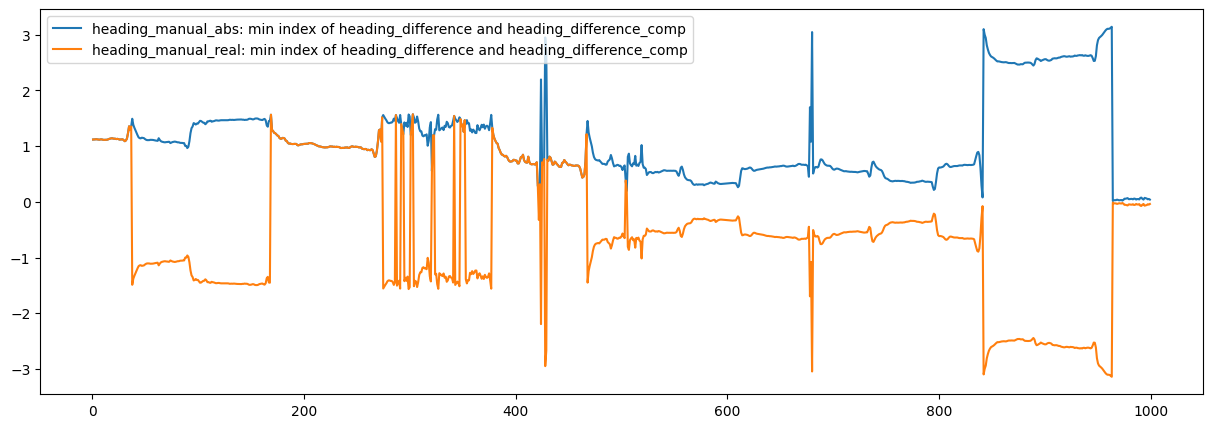

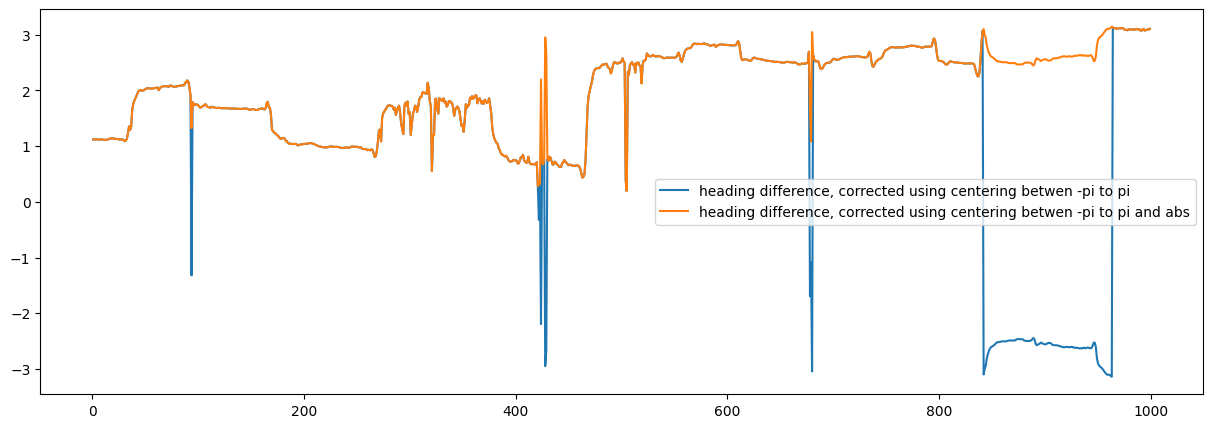

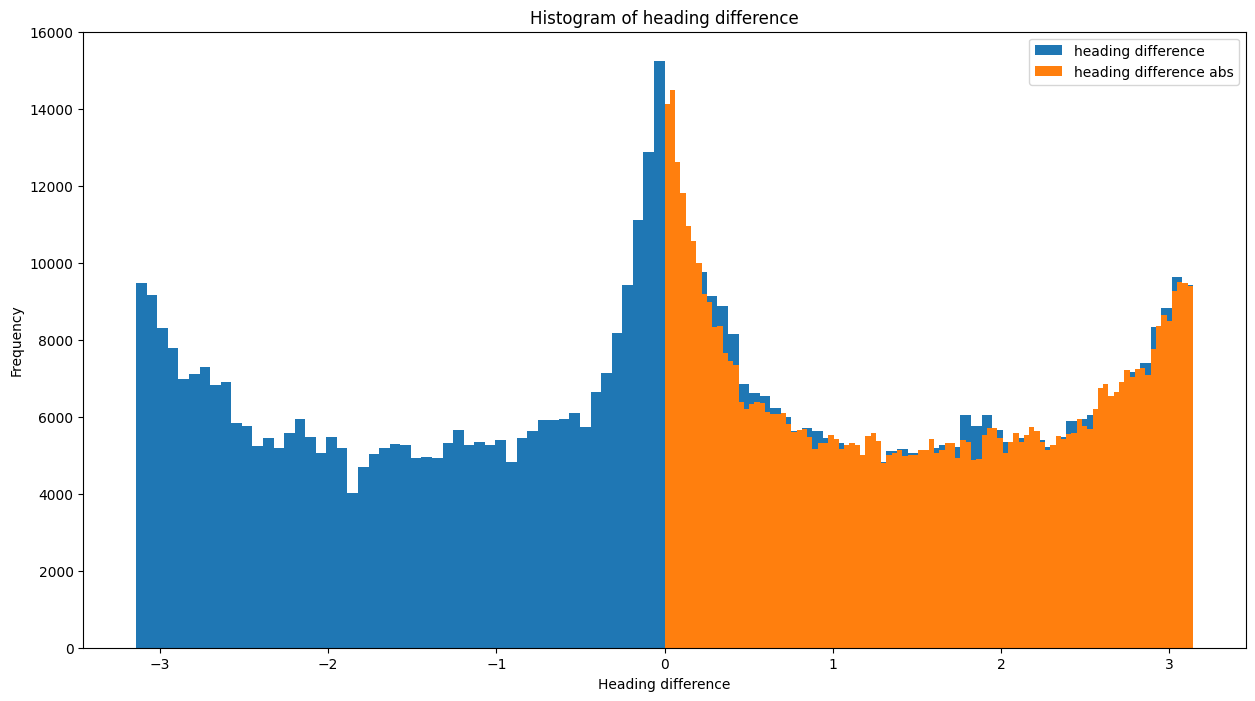

following_mod: [[0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
Percent following: 89.27%
Percent following real: 89.27%
Percent following mod: 100.00%
length of filtered_df: 654944
length of transitioned df: 654944
rf_behind_vf: [1 1 1 ... 0 0 0]
proportion of time fish is behind: 0.48772719499682415


C:\Users\kkumari\AppData\Local\Temp\ipykernel_21444\733572900.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'x_o'] = x_o
C:\Users\kkumari\AppData\Local\Temp\ipykernel_21444\733572900.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'y_o'] = y_o


length of final_df:  319434


In [21]:
df = calc_relative_heading(df)


In [22]:
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

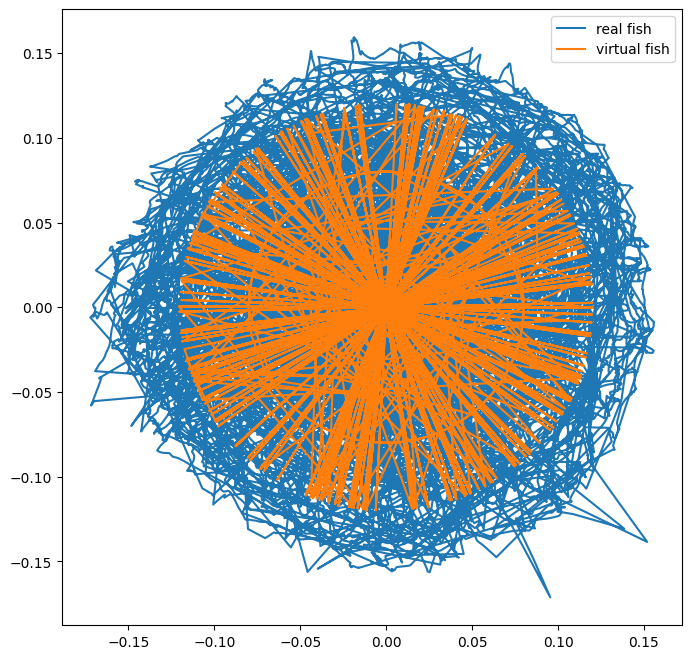

In [23]:
fig = plt.figure(figsize=(8,8))
plt.plot(df['x_rf'], df['y_rf'], label='real fish')
plt.plot(df['x_vf'], df['y_vf'], label='virtual fish')
plt.legend()
plt.show()



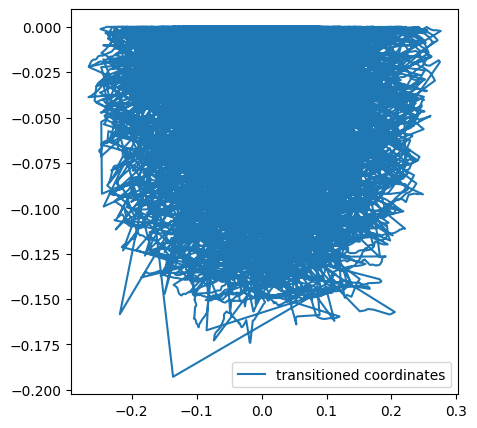

In [24]:
# plot transitioned coordinates

fig = plt.figure(figsize=(5,5))
plt.plot(df['x_o'], df['y_o'], label='transitioned coordinates')
plt.legend()
plt.show()


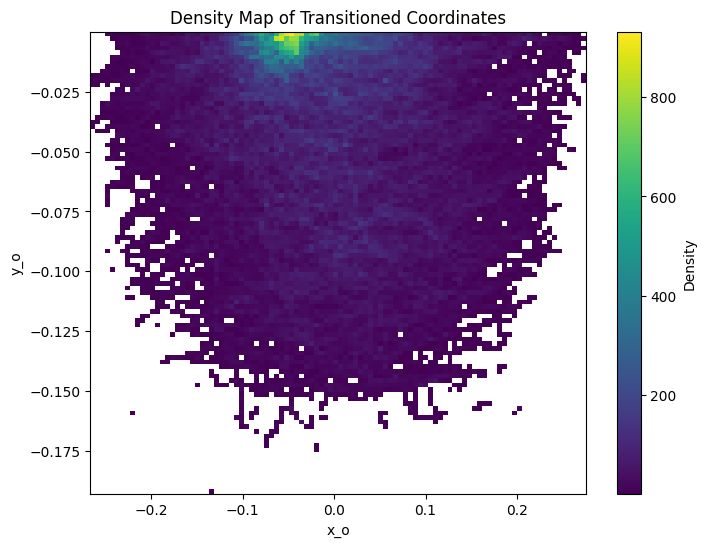

In [25]:
fig = plt.figure(figsize=(8, 6))
plt.hist2d(df['x_o'], df['y_o'], bins=100, cmap='viridis', cmin=1)
plt.colorbar(label='Density')
plt.xlabel('x_o')
plt.ylabel('y_o')
plt.title('Density Map of Transitioned Coordinates')
plt.show()

In [26]:
r_rf, theta_rf = cartesian_to_polar(df['x_rf'], df['y_rf'])
r_vf, theta_vf = cartesian_to_polar(df['x_vf'], df['y_vf'])

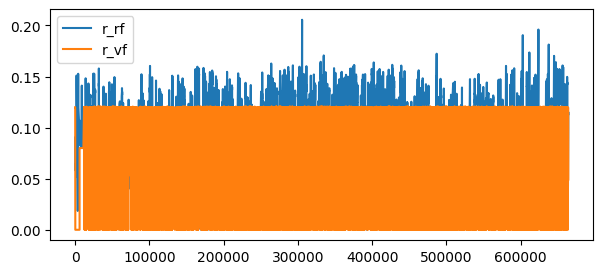

In [27]:
# summarise r_rf and r_vf

fig = plt.figure(figsize=(7,3))
plt.plot(r_rf, label='r_rf')
plt.plot(r_vf, label='r_vf')
plt.legend()
plt.show()


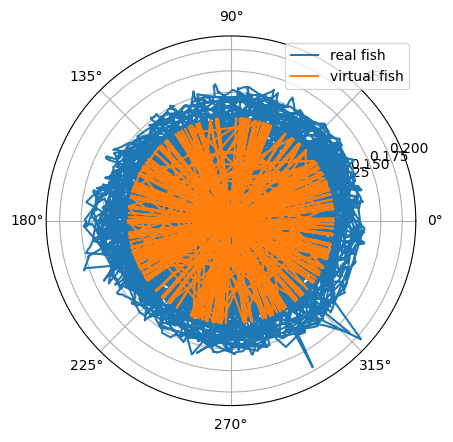

In [28]:
# Create a polar subplot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_rf, r_rf, label='real fish')
ax.plot(theta_vf, r_vf, label='virtual fish')
ax.legend()
plt.show()
